In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.1


# Environment prep for Colab
 - download git repo 
 - install required pip packages

In [3]:
#!git clone https://github.com/aykhangaffarov/Generative_Models # this is for loading git with correct brach

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
#!mkdir /content/drive/My\ Drive/Results
#MAIN_SAVE_DIR = '/content/drive/My Drive/Results'
#IMG_DIR = '/content/Generative_Models/data/.CBSD68' #change .qbert here as well



In [5]:
#!mv Generative_Models/data/.CBSD68/CBSD68.tar.bz Generative_Models/data/

# Settings

In [6]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
sys.path.append('..'+sep_local+'..')
print(sep_local)

env: TF_KERAS=1
\


In [7]:
os.chdir('..'+sep_local+'..'+sep_local+'..'+sep_local+'..'+sep_local+'..'+sep_local+'..'+sep_local)
print(os.getcwd())

C:\Users\Kriple\PycharmProjects\Generative_Models


In [8]:
!pip -q install -r requirements.txt

# Unzip

In [9]:
#!tar -xvf data/CBSD68_low2high_LMDB.tar.bz 

In [10]:
#!mv data/.CBSD68_low2high_LMDB/ data/SR

In [11]:
#!ls data/SR

# **Loading** Dataset

In [12]:
from training.generators.from_lmdb.lmdb_image_generator import get_generators

In [13]:
dataset_name='CBSD68_low2high'
lmdb_dir = 'data/.CBSD68_low2high_LMDB'

In [14]:
batch_size = 16
latents_dim = 150
intermediate_dim = 50

In [15]:
from transformation.lmdb_transformer import LmdbTransformer

In [16]:
#inputs_shape = list(map(lambda x: x//2 , image_size[:-1])) + [image_size[-1]]
#inputs_shape = (*inputs_shape, )

In [17]:
#shrink_fn = lambda image: tf.image.resize(image, inputs_shape[:-1])
#enlarge_fn = lambda image: tf.image.resize(image, image_size[:-1])

In [18]:
def generator_reshaper(itr): 
    while True:
        batch = next(itr)
        yield batch['image_target'], batch['image_source']

In [19]:
train_itr, val_itr = get_generators(
        lmdb_dir=lmdb_dir,
        batch_size=batch_size,
        episode_len=None,
        episode_shift=None,
        return_itr=True,
        class_mode='sr'
)

Initializing Iterator training Number of images 48
Initializing Iterator validation Number of images 20


C:\Users\Kriple\PycharmProjects\Generative_Models\transformation\file_image_generator.py:51: UserWarning: No files found
  warnings.warn(msg)


In [20]:
data = next(train_itr)
print(data.keys())

dict_keys(['image_source', 'image_target', 'dir', 'filename', 'source_channels', 'source_size', 'target_channels', 'target_size'])


In [21]:
import matplotlib.pyplot as plt

In [22]:
from PIL import Image

In [23]:
import numpy as np

In [24]:
source_img_size, target_img_size =  data['image_source'][0].shape, data['image_target'][0].shape
source_img_size, target_img_size

((321, 481, 3), (107, 160, 3))

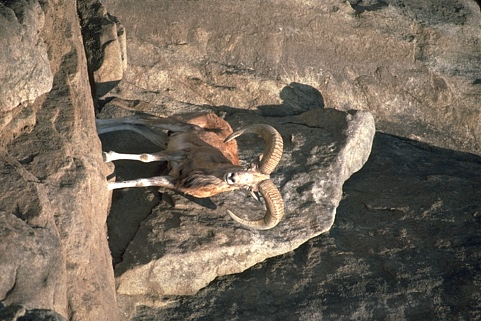

In [25]:
Image.fromarray((data['image_source'][0] * 255.0).astype(np.uint8), mode='RGB')

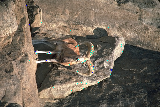

In [26]:
Image.fromarray((data['image_target'][0] * 255.0).astype(np.uint8), mode='RGB')

In [27]:
image=data['image_target'][0]

In [28]:
def generator_reshaper(itr): 
    while True:
        batch = next(itr)
        yield batch['image_target'], batch['image_source']

In [29]:
import tensorflow as tf

In [30]:
train_generator = tf.data.Dataset.from_generator(
    lambda: generator_reshaper(train_itr), 
    output_types= (tf.float32, tf.float32),
)
val_generator = tf.data.Dataset.from_generator(
    lambda: generator_reshaper(val_itr), 
    output_types= (tf.float32, tf.float32),
)

In [31]:
import numpy as np
from collections.abc import Iterable
if isinstance(source_img_size, Iterable):
    flat_outputs_shape = np.prod(source_img_size)
flat_outputs_shape    

463203

# Model's Layers definition

In [32]:
kernel_size=3
stride = 2

In [33]:
c = list(map(lambda x: x// (stride*stride), source_img_size[:-1]))
c = (*c, intermediate_dim)
c

(80, 120, 50)

In [34]:
enc_lays = [
    tf.keras.layers.UpSampling2D(size=(2, 2)),
    tf.keras.layers.UpSampling2D(size=(2, 2)),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(latents_dim)
]

dec_lays = [
    tf.keras.layers.Dense(units=np.product(c), activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=c),
    tf.keras.layers.Conv2DTranspose(filters=intermediate_dim, kernel_size=kernel_size, strides=(stride, stride), padding="SAME", activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=intermediate_dim, kernel_size=kernel_size, strides=(stride, stride), padding="SAME", activation='relu'),
    # No activation
    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=kernel_size, strides=(1, 1), padding="SAME")
]

# Model definition

In [35]:
model_name = dataset_name+'_Conv_Pre_Upsampling_LMDB'
#windows
#experiments_dir='..' + sep_local + '..' + sep_local +'..' + sep_local + '..' + sep_local + '..'+sep_local+'experiments'+sep_local + model_name

#linux 
experiments_dir=os.getcwd()+ sep_local  +'experiments'+sep_local + model_name

In [36]:
variables_params = \
[
    {
        'name': 'inference',  #'upsampler',
        'inputs_shape':target_img_size,
        'outputs_shape':latents_dim,
        'layers': enc_lays
    }

    ,
    
        {
        'name': 'generative', #'constructive', 
        'inputs_shape':latents_dim,
        'outputs_shape':source_img_size,
        'layers':dec_lays
    }
]

In [37]:
from os.path import abspath
from utils.data_and_files.file_utils import create_if_not_exist
_restore = os.path.join(experiments_dir, 'var_save_dir')
create_if_not_exist(_restore)
absolute = abspath(_restore)
print("Restore_dir",absolute)
absolute = abspath(experiments_dir)
print("Recording_dir",absolute)
print("Current working dir",os.getcwd())

Restore_dir C:\Users\Kriple\PycharmProjects\Generative_Models\experiments\CBSD68_low2high_Conv_Pre_Upsampling_LMDB\var_save_dir
Recording_dir C:\Users\Kriple\PycharmProjects\Generative_Models\experiments\CBSD68_low2high_Conv_Pre_Upsampling_LMDB
Current working dir C:\Users\Kriple\PycharmProjects\Generative_Models


In [38]:
from training.autoencoding_basic.transformative.AE import autoencoder as AE

In [39]:
ae = AE( 
    name=model_name,
    latents_dim=latents_dim,
    batch_size=batch_size,
    variables_params=variables_params, 
    filepath=None,#to restore trained model, set filepath=_restore
    episode_len=1
    )

  WARNING  | None
  WARNING  | None


Model: "inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_inputs (InputLayer [(None, 107, 160, 3)]     0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 214, 320, 3)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 428, 640, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 821760)            0         
_________________________________________________________________
dense (Dense)                (None, 150)               123264150 
_________________________________________________________________
batch_normalization (BatchNo (None, 150)               600       
_________________________________________________________________
dropout (Dropout)            (None, 150)               0 

  WARNING  | None
  WARNING  | None


Model: "generative"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generative_inputs (InputLaye [(None, 150)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 480000)            72480000  
_________________________________________________________________
reshape (Reshape)            (None, 80, 120, 50)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 160, 240, 50)      22550     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 320, 480, 50)      22550     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 320, 480, 3)       1353      
_________________________________________________________________
batch_normalization_1 (Batch (None, 320, 480, 3)       1

In [40]:
ae.compile(output_fn=lambda x: tf.image.resize(x, source_img_size[:-1]), metrics=None)

Model: "CBSD68_low2high_Conv_Pre_Upsampling_LMDB"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_inputs (InputLayer [(None, 107, 160, 3)]     0         
_________________________________________________________________
inference (Functional)       (None, 150)               123264750 
_________________________________________________________________
generative (Functional)      (None, 320, 480, 3)       72526465  
_________________________________________________________________
tf_op_layer_x_logits (Tensor [(None, 320, 480, 3)]     0         
Total params: 195,791,215
Trainable params: 195,790,909
Non-trainable params: 306
_________________________________________________________________
None


In [41]:
#ae.compile(metrics=None)

#ae.compile(metrics=create_metrics())
#ae.compile()

# Callbacks

In [42]:
# added for linux warning suppression
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)


from training.callbacks.trace_image_reconstruction import trace_reconstruction
from training.callbacks.save_model import ModelSaver

In [43]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=1e-12, 
    patience=12, 
    verbose=1, 
    restore_best_weights=False
)

In [44]:
ms = ModelSaver(filepath=_restore)

In [45]:
csv_dir = os.path.join(experiments_dir, 'csv_dir')
create_if_not_exist(csv_dir)
csv_dir = os.path.join(csv_dir, model_name+'.csv')
csv_log = tf.keras.callbacks.CSVLogger(csv_dir, append=True)
absolute = abspath(csv_dir)
print("Csv_dir",absolute)

Csv_dir C:\Users\Kriple\PycharmProjects\Generative_Models\experiments\CBSD68_low2high_Conv_Pre_Upsampling_LMDB\csv_dir\CBSD68_low2high_Conv_Pre_Upsampling_LMDB.csv


In [46]:
image_reconstuction_dir = os.path.join(experiments_dir, 'image_reconstuction_dir')
create_if_not_exist(image_reconstuction_dir)
absolute = abspath(image_reconstuction_dir)
print("image_reconstuction_dir",absolute)

image_reconstuction_dir C:\Users\Kriple\PycharmProjects\Generative_Models\experiments\CBSD68_low2high_Conv_Pre_Upsampling_LMDB\image_reconstuction_dir


In [47]:
img_reconst = trace_reconstruction(filepath=image_reconstuction_dir, image=image, gen_freq=5)

# Model Training

In [ ]:
ae.fit(
    x=train_generator,
    input_kw=None,
    steps_per_epoch=5,#int(1e4),
    epochs=5,#int(1e6), 
    verbose=1,
    #callbacks=[ es, ms, csv_log, img_reconst],
    workers=-1,
    use_multiprocessing=True,
    validation_data=val_generator,
    validation_steps=int(1e4)
    )

Epoch 1/5
